# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from IPython.display import display, HTML

sys.path.append('..')
from models import utils
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

%matplotlib inline

In [3]:
def fix_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
fix_seeds()

# Models

## Linear regression with L2 regularization on weights (Ridge regression)

The linear regression model is defined as: $\hat{y} = w^{T} x + b$ where $\hat{y}$ is a scalar function to estimate.

Ordinary least squares with L2 regularization is the optimization problem defined as $ \min_{w, b} = \lVert X w - y \lVert_{2}^{2} + \lambda\lVert w \lVert_{2}^{2} $

It is explicitly solved as an analytical solution exists: $ w^{*} = (X^{T}X + \lambda I)^{-1} X^{T} y $

Model RMSE: 8.05


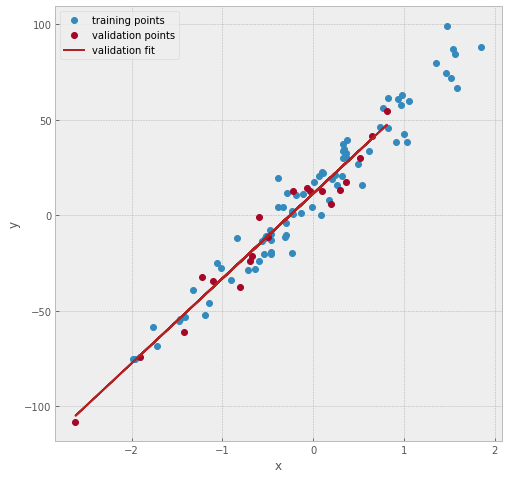

In [4]:
from models.linear_models import RidgeRegression


def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true - y_hat)**2))

X, y = make_regression(n_samples=100, n_features=1, n_targets=1, bias=10., noise=10.)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

ridge_regressor = RidgeRegression()
ridge_regressor.fit(X_train, y_train)
y_hat = ridge_regressor.predict(X_val)

model_rmse = rmse(y_val, y_hat)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X_train, y_train, lw=0., marker='o', label='training points')
ax.plot(X_val, y_val, lw=0., marker='o', label='validation points')
ax.plot(X_val, y_hat, label='validation fit', c='firebrick')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()
print(f'Model RMSE: {model_rmse:.2f}')

## Ridge regression with prediction intervals

Adaptation of the blog post [Bootstrapping prediction intervals](https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/) for multi-point predictions.
It estimates prediction intervals by bootstrapping on the training set and adjust the residuals to account for overfitting using the procedure described in "Elements of Statistical Learning", 7.11. 

The advantage of the method is that it is non-parametric so it does not make assumptions on the target distribution and model used. 

Nevertheless, it is computationally expensive as it fits the base model several times and the "no information error rate" computation has a memory complexity of $N^2$ where $N$ is the number of training samples.

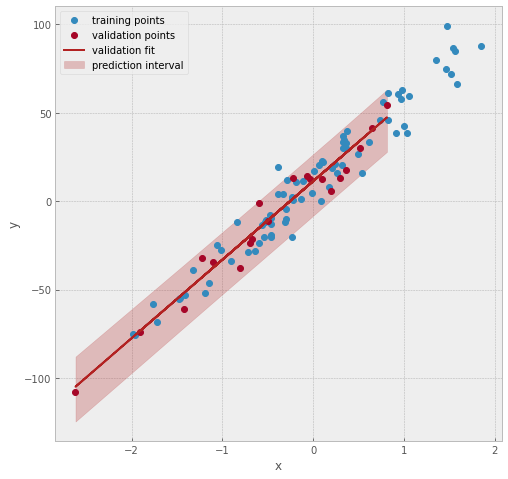

In [5]:
from models.meta import PredictionIntervals


meta = PredictionIntervals(ridge_regressor)
meta.fit(X_train, y_train)
y_hat, percentiles = meta.predict(X_val)
sorted_inds = X_val.ravel().argsort()

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X_train, y_train, lw=0., marker='o', label='training points')
ax.plot(X_val, y_val, lw=0., marker='o', label='validation points')
ax.plot(X_val, y_hat, label='validation fit', c='firebrick')
ax.fill_between(X_val[sorted_inds,:].ravel(), percentiles[0, sorted_inds], percentiles[1, sorted_inds], color='firebrick', alpha=.25, label='prediction interval')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()

## Kernel regression

This is a simple non-parametric estimator based on the Nadaraya–Watson estimator. Kernel regression estimates the conditional expectation $E(Y|X)$ of random variables $X$ and $Y$.

Nadaraya–Watson estimator is defined as $E(y_{i}|x_{i}) = \frac{ \sum_{j} K_{ij} y_{i} }{\sum_{j} K_{ij}} $ where $K_{ij} = K(x_{i}^{test}, x_{j}^{train})$ are the elements of the similarity matrix of shape (number of training samples, number of test samples), as returned by the kernel function. They express a notion of similarity between two samples.

Text(0, 0.5, 'y')

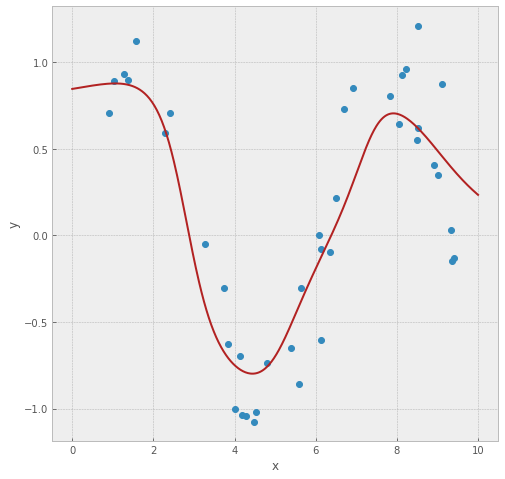

In [90]:
from models.kernel_regression import KernelRegression, RBFKernel, PolyKernel


X = np.sort(10 * np.random.rand(40, 1), axis=0)
X_test = np.linspace(0, 10, 500)[:, None]
y = np.sin(X).ravel() 
y = y + np.random.normal(0, .2, y.shape)

rbf = RBFKernel(gamma=1)
kernel_regression = KernelRegression(rbf)
kernel_regression.fit(X, y)
y_hat = kernel_regression.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X, y, lw=0., marker='o')
ax.plot(X_test, y_hat, c='firebrick')
ax.set_xlabel('x')
ax.set_ylabel('y')

## Locally weighted regression (LOESS/LOWESS)

Non parametric method for smoothing a signal that perform a moving weighted average using a gaussian kernel. The parameter sigma defines the brandwidth of the kernel (how the gaussian is flattened so how much farther points impact the current point) while the parameter frac defines how many points are taken into account, so how smooth the result is.

Text(0, 0.5, 'y')

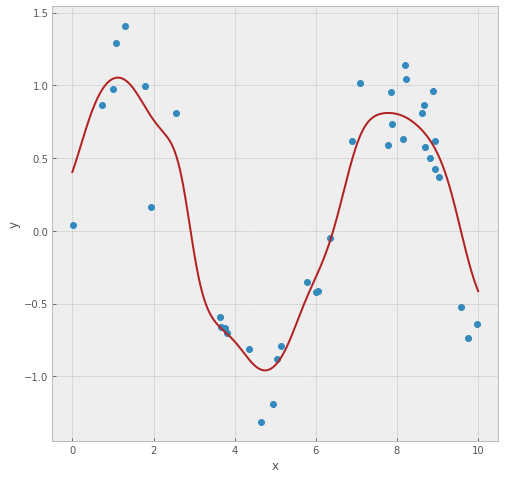

In [133]:
from models.smoothing import LOWESS


X = np.sort(10 * np.random.rand(40, 1), axis=0)
X_test = np.linspace(0, 10, 500)[:, None]
y = np.sin(X).ravel() 
y = y + np.random.normal(0, .2, y.shape)

lowess = LOWESS(sigma=.5, frac=1.)
lowess.fit(X, y)
y_hat = lowess.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X, y, lw=0., marker='o')
ax.plot(X_test, y_hat, c='firebrick')
ax.set_xlabel('x')
ax.set_ylabel('y')

## Logistic regression

Logistic regression is a linear model used for binary classification (despite the "regression" term in its name). It is basically a linear regression model inside a sigmoid:

$ \hat{y} = z(w^{T}x + b) $ where $ z(x) = \frac{1}{1 + e^{-x}} $

The target $y$ is valued in $\{0, 1\}$ and represents a probability of a binary outcome. The sigmoid is used to transform the linear function output $ w^{T}x + b$ valued in $\{-\infty, \infty \} $ for a given sample to a probability.

The decision function parametrized by $ w $ and $ b $ is learned using Stochastic Gradient Descent (SGD) on the Binary Cross Entropy loss (BCE):

$ L(y; w, b) = \frac{1}{m} ( \, -y^{T} \log(\hat{y}) - (1 - y)^{T} \log(1 - \hat{y}) ) \, + \lambda R(w) $ where $ R(w) $ is a regularization term. Here, $l_{2}$ norm is chosen as regularization function.

SGD is an iterative procedure based on the gradient descent algorithm. At each iteration, model parameters are updated:
$ w^{(i+1)} = w^{(i)} - \eta * ( \lambda \frac{\partial R(w)}{\partial w} + \frac{\partial L(y; w, b)}{\partial w} ) $ where $ \eta $ is the learning rate.

In the case of the logistic regression, the weights update expression simplifies to 
$ w^{(i+1)} = w^{(i)} - \eta * ( 2 \lambda w + \frac{1}{m} X^{T} ( \hat{y} - y ) ) $

Model F1: 0.82


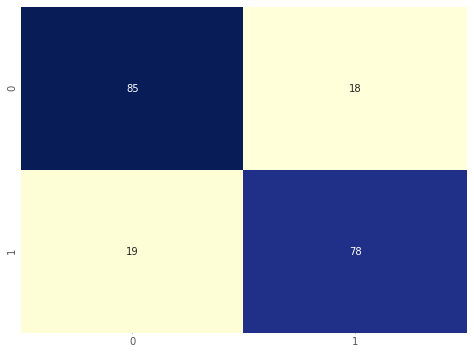

In [37]:
from models.linear_models import LogisticRegression


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

logistic_classfier = LogisticRegression()
logistic_classfier.fit(X_train, y_train)
y_hat = logistic_classfier.predict(X_val)

cm = utils.confusion_matrix(y_val, y_hat)
model_f1 = utils.f1_score(cm)
print(f'Model F1: {model_f1:.2f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='YlGnBu', ax=ax)

## K-NN regression (Euclidean distance)

Nearest neighbors methods are non parametric methods that are widely used both for supervised learning (regression and classification problems) and unsupervised, such as clustering. The base concept is to consider that the data lives on a flat manifold where close points w.r.t to some distance measure can be assumed to be similar. 

In the case of K-NN regression, the distribution that maps known data points $X$ to the target variable $y$ is interpolated using $k$ closest points using a proper distance metric:
* In the 'uniform' case, the prediction $\hat{y}$ for a new point $x$ is simply the average $y_{i}$ for every $i$ in the neighborhood of $x$ composed of the $k$ nearest points.
* In the 'distance' case, the predictions $\hat{y}$ is instead of a weighted average of $y_{i}$, where weights are the inverse of the distance to the new point $x$.

This is a naive implementation using a distance matrix $D = [ d_{ij} ]$ where $d_{ij}$ is the euclidean distance between known data points $x_{i}^{train}$ and a new point $x_{j}^{test}$. The use of the euclidean distance allow to implement the computation of this distance matrix by only using numpy optimized functions:
$ d_{ij}^{2} = - 2 X_{train} X_{test}^{T} + \sum_{k} (x_{ik}^{train})^{2} + \sum_{k} (x_{jk}^{test})^{2} $

K-NN classification is similar, differing on that instead of returning the average of the target over the neighbors, the classifier returns the most frequent class over the neighbors.

Text(0.5, 1.0, 'Inverse distance KNN interpolation')

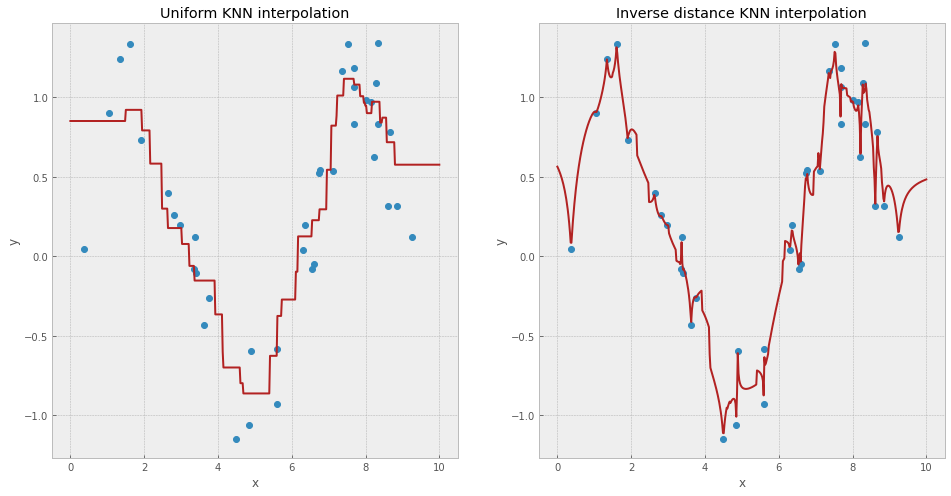

In [40]:
from models.knn import KNNRegressor
from sklearn.datasets import make_regression


X = np.sort(10 * np.random.rand(40, 1), axis=0)
X_test = np.linspace(0, 10, 500)[:, None]
y = np.sin(X).ravel() 
y = y + np.random.normal(0, .2, y.shape)

knn_regressor = KNNRegressor(weights='uniform')
knn_regressor.fit(X, y)
y_hat_uniform = knn_regressor.predict(X_test)

knn_regressor = KNNRegressor(weights='distance')
knn_regressor.fit(X, y)
y_hat_distance = knn_regressor.predict(X_test)

fig, (ax_uniform, ax_distance) = plt.subplots(ncols=2, figsize=(16, 8))
ax_uniform.plot(X, y, lw=0., marker='o')
ax_uniform.plot(X_test, y_hat_uniform, c='firebrick')
ax_uniform.set_xlabel('x')
ax_uniform.set_ylabel('y')
ax_uniform.set_title('Uniform KNN interpolation')

ax_distance.plot(X, y, lw=0., marker='o')
ax_distance.plot(X_test, y_hat_distance, c='firebrick')
ax_distance.set_xlabel('x')
ax_distance.set_ylabel('y')
ax_distance.set_title('Inverse distance KNN interpolation')

## Decision trees classifier

Decisions trees are binary trees where each node splits a feature given a threshold that minimizes a criterion, and which is learned during training. By essence, this process is recursive.

Given $(X^{r}, y^{r})$ at each recursion step $r$, information gains between $y^{r}$ of the current node and all the combinations $y_{i,t}^{r}$ where $i$ is the i-th feature and t the threshold to test the split on are computed. The best (feature, threshold) found then define the next split. For a branch, the process continues until the maximum depth is reached, or if all the labels are the same. In the case of continuous features, feature values are quantized to reduce the number of combinations to test.

The information gain is defined as $ IG(y, y_{left}, y_{right}) = loss(y) - \frac{1}{N_{left} + N_{right}} ( N_{left} \cdot loss (y_{left}) + N_{right} \cdot loss (y_{right})) $ where $y_{left/right}$ are the labels of the samples split w.r.t a given threshold on a given feature, and $N_{left/right}$ are the number of labels in each groups. It is basically a loss difference where the child losses are weighted.

The loss used for classification is usually the entropy (information theory one) defined as $ E(y) = - \sum_{i \in C} p_{i} \log_{2} p_{i} $ over the classes $C$, where $p_{i} $ is simply the fraction of labels of class $c_{i}$ in the group.

To make predictions, the tree is traversed for each new points until it reaches a leaf. The most common class inside the leaf is returned as the predicted value.

This model can be used for regression to: instead of the entropy loss, the mean squared error can be used and instead of storing probabilities of the targets in the leafs, the average value of the targets is stores.

Model F1: 0.80


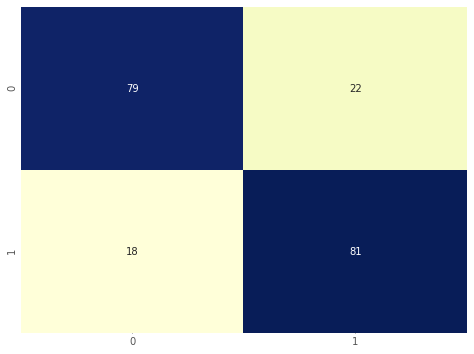

In [15]:
from models.trees import DecisionTreeClassifier


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

dt_classfier = DecisionTreeClassifier()
dt_classfier.fit(X_train, y_train)
y_hat = dt_classfier.predict(X_val)

cm = utils.confusion_matrix(y_val, y_hat)
model_f1 = utils.f1_score(cm)
print(f'Model F1: {model_f1:.2f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='YlGnBu', ax=ax)

## Random forest

Random forests are a natural extension of decision trees: instead of learning one tree on the dataset, random forests train $N_{T}$ trees on a subset of the original dataset. Each tree learns decision rules on a boostraped version of the original dataset (sampling with replacement on the samples) and on a subset of the feature space (features bagging). 

At inference time, predictions of each trees of the forest are aggregated to supply the final prediction: either by averaging in the case of regressions, or by taking the most frequent class in the case of classification problems.

Feature bagging prevents the trees to be highly correlated if a few features are strong predictors of the target. Bootstraping allow to make the model more robust to noise as long as trees are not strongly correlated and avoid ending up with strongly correlated trees, simply because they are trained on different subsets of the original dataset.

Model F1: 0.91


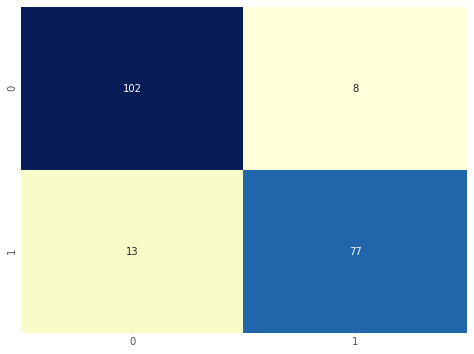

In [19]:
from models.trees import RandomForestClassifier


X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

rf_classfier = RandomForestClassifier(n_trees=10)
rf_classfier.fit(X_train, y_train)
y_hat = rf_classfier.predict(X_val)

cm = utils.confusion_matrix(y_val, y_hat)
model_f1 = utils.f1_score(cm)
print(f'Model F1: {model_f1:.2f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='YlGnBu', ax=ax)


## K-means

Unsupervised algorithm that greedily finds K partitions $ S=\{ S_k\} $ over N $ X=\{x_n\} $ observations that minimize intra-cluster variance. This problem is expressed as : $ argmin_S \sum_{i=0}^{K} \sum_{x \in S_i} \parallel x - \mu_i \parallel^2 $

Score: 3.53


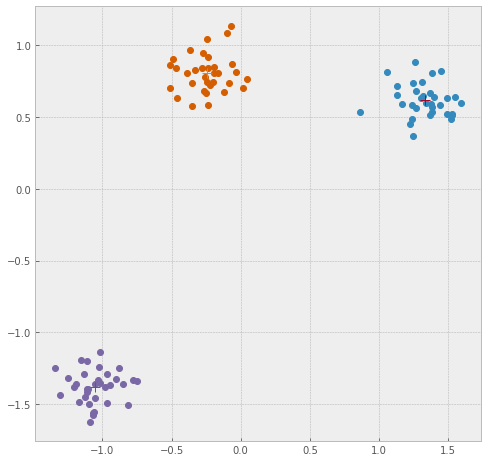

In [6]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from models.kmeans import KMeans


n_clusters = 3
X, y = make_blobs(n_samples=100, centers=n_clusters, n_features=2)

kmeans = KMeans(n_clusters)
X = StandardScaler().fit_transform(X)
labels = kmeans.fit(X)
centroids = kmeans._cluster_centroids

print(f'Score: {kmeans._score:.2f}')
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(n_clusters):
    label_mask = (labels == i)
    ax.plot(X[label_mask, 0], X[label_mask, 1], lw=0, marker='o')
    ax.plot(centroids[i, 0], centroids[i, 1], marker='+', markersize=10)

## Gaussian mixtures

Gaussian mixture is a generative model that models a probability distribution as a weighted sum of normal distributions:

$ p(X; \mu , \Sigma) = \sum_k { w_{k} \mathcal{N}(\mu_{k},\,\Sigma_{k}) } $ where $ \sum_k { w_{k} = 1 } $ 

It can be used in a non-supervised setting where each normal distribution $ k $ represents a cluster, and the probability $ p(x_{i} \in C_k; \mu , \Sigma) $ is the probability that the point $ x_{i} $ belongs to the cluster $ C_{k} $.

Parameters $ \{ \mu_k, \Sigma_k \} $ of the $ k $ normal distributions are learned from the data using the Expectation Maximization algorithm that maximizes the conditionnal probability $ p(\Theta | X) $ of observing the parameters of the model $ \Theta $ given the data $ X $.

In the context of GMM, expectation maximization is as follows:

* Randomly initialize $ \{ \mu_k, \Sigma_k \} $ by taking $ k $ points from $ X $ and the whole dataset covariance matrix
* Iterate until the log-likehood $ L (\Theta) = \sum_i log \left( \sum_k { w_{k} \mathcal{N}(\mu_{k},\,\Sigma_{k}) } \right) $ converges to a local minima:
    * Expectation step: compute $ p(C_k | x_{i}, \mu , \Sigma) = \frac{w_k \mathcal{N}(x_{i} | \mu_{k},\,\Sigma_{k})}{\sum_k w_k \mathcal{N}(x_{i} | \mu_{k},\,\Sigma_{k})} $ the conditional expectation of component assignment for each data point, given the model parameters
    * Maximization step: update weights $ w_k = \frac{1}{N} \sum_{i} p(C_k | x_{i}, \mu , \Sigma) $, means $ \mu_k = \frac {\sum_i x_i p(C_k | x_{i}, \mu , \Sigma)}{\sum_i p(C_k | x_{i}, \mu , \Sigma)} $ and covariances $ \Sigma_k = \frac{ p(C_k | x_{i}, \mu , \Sigma)}{\sum_i p(C_k | x_{i}, \mu , \Sigma)}(X - \mu_k)^T (X - \mu_k) $ 
    
GMM in the context of clustering output a probability distribution and as such soft assignements as oposed to discriminative approaches such as K-means where cluster assignements are hard (only one cluster for each point).

Log likehood: -11581.43


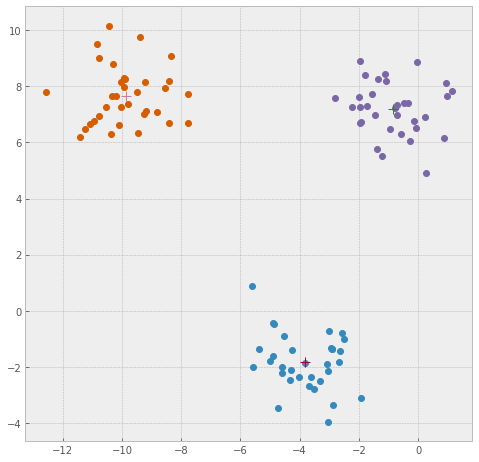

In [399]:
from sklearn.datasets import make_blobs
from models.mixture_models import GaussianMixture

n_clusters = 3
X, y = make_blobs(n_samples=100, centers=n_clusters, n_features=2)

gm = GaussianMixture(n_components=3)
probs = gm.fit_predict(X)
centroids = gm._mu.T
labels = probs.argmax(axis=1)

print(f'Log likehood: {gm._loss:.2f}')
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(n_clusters):
    label_mask = (labels == i)
    ax.plot(X[label_mask, 0], X[label_mask, 1], lw=0, marker='o')
    ax.plot(centroids[i, 0], centroids[i, 1], marker='+', markersize=10)

## PCA

Build a subspace of given dimension on which to project the data. It is generated by the eigen vectors corresponding to the k highest eigen values (or dimensions containing the most variance). The algorithm apply the following steps:
* compute covariance matrix of centered X
* compute k eigen vectors $V=\{v_i\}_k$ corresponding to the k larger eigenvalues $\lambda=\{\lambda_i\}_k$
* project onto $span(V)$, the subspace generated by $V$
            
As the covariance matrix of X is symmetric, its eigen vectors are orthogonal, and as such the covariance of the projection of X in the subspace generated by its eigen vectors is a diagonal matrix where entries are its eigen values. The explained variance ratio per principal direction is simply the corresponding eigen value divided by the sum of all the eigen values (which is the total variance).

Explained variance: 97.77%


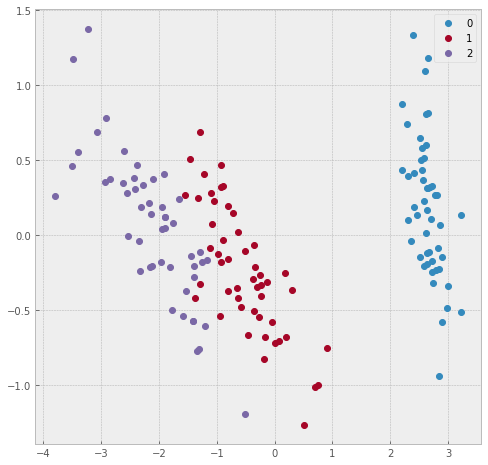

In [245]:
from sklearn import datasets
from models.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
y = iris.target

pca = PCA(2)
X_transformed = pca.fit_transform(X)
print(f'Explained variance: {100 * pca.explained_variance_ratio.sum():.2f}%')

fig, ax = plt.subplots(figsize=(8, 8))
for i in np.unique(y):
    label_mask = (y == i)
    ax.plot(X_transformed[label_mask, 0], X_transformed[label_mask, 1], lw=0, marker='o', label=i)
    
ax.legend()